# Counting results

In [2]:
import pandas as pd
from matplotlib_venn import venn3
from matplotlib import pyplot as plt

## 1. Journals

Taxonomic journals:
- with title
- found on wikidata (each method)
- found on OpenAlex
- total
- still publishing in the last 10 years
- dissolved (confirmed)
- with ISSN-L
- with IPNI publication ID
- with ZooBank publication ID
- with OpenAlex ID

In [2]:
journals = pd.read_csv("../data/processed/journals_deduplicated.csv")
journals.head()

,title,wikidataURL,ISSN-L,IPNIpubID,ZooBankPubID,openAlexID,dissolvedYear,dissolved,source
0,Ornithology,http://www.wikidata.org/entity/Q2300649,0004-8038,NaN,3F3F951F-B494-44B0-B286-AF9BCB097966,S152904045,NaN,NaN,Wikidata taxonomic subject
1,ZooKeys,http://www.wikidata.org/entity/Q219980,1313-2970,NaN,91BD42D4-90F1-4B45-9350-EEF175B1727A,S199213172,NaN,NaN,Wikidata taxonomic subject
2,Zootaxa,http://www.wikidata.org/entity/Q220370,1175-5326,NaN,78F99150-21C2-4639-B359-F3E2302DF0B7,S171471881,NaN,NaN,Wikidata taxonomic subject
3,Nuytsia,http://www.wikidata.org/entity/Q2005798,0085-4417,1029-2,NaN,S103214341,NaN,NaN,Wikidata taxonomic subject
4,Kew Bulletin,http://www.wikidata.org/entity/Q2675794,0075-5974,987-2,NaN,S157974409,NaN,NaN,Wikidata taxonomic subject


In [3]:
print("Number of journals: " + str(len(journals)))
print("Number of journals with known title: "+\
      str(len([x for x in journals["title"] if x == x])))

Number of journals: 2238
Number of journals with known title: 2238


In [4]:
for column in journals.columns[1:6]:
    print("Number of journals with " + column + ": "+\
          str(len([x for x in journals[column] if x == x])))

Number of journals with wikidataURL: 2195
Number of journals with ISSN-L: 1389
Number of journals with IPNIpubID: 1579
Number of journals with ZooBankPubID: 624
Number of journals with openAlexID: 776


In [5]:
print("Journals that were dissolved (confirmed): ")
journals["dissolved"].value_counts()

Journals that were dissolved (confirmed): 


True     475
False    128
Name: dissolved, dtype: int64

In [6]:
articles = pd.read_pickle("../data/interim/filtered_articles.pkl")
articles.head()

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,source_is_in_doaj,source_host_organization,source_host_organization_name,source_host_organization_lineage,source_host_organization_lineage_names,source_type,oa_is_oa,oa_oa_status,oa_oa_url,oa_any_repository_has_fulltext
0,https://openalex.org/W2766208183,https://doi.org/10.1371/journal.pone.0185809,More than 75 percent decline over 27 years in ...,More than 75 percent decline over 27 years in ...,2017,2017-10-18,{'openalex': 'https://openalex.org/W2766208183...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",article,...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://doi.org/10.1371/journal.pone.0185809,True
1,https://openalex.org/W1577451703,https://doi.org/10.1371/journal.pone.0131080,Biodiversity on the Rocks: Macrofauna Inhabiti...,Biodiversity on the Rocks: Macrofauna Inhabiti...,2015,2015-07-09,{'openalex': 'https://openalex.org/W1577451703...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",article,...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True
2,https://openalex.org/W2072022921,https://doi.org/10.1371/journal.pone.0066213,A DNA-Based Registry for All Animal Species: T...,A DNA-Based Registry for All Animal Species: T...,2013,2013-07-08,{'openalex': 'https://openalex.org/W2072022921...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",article,...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True
3,https://openalex.org/W2037158686,https://doi.org/10.1371/journal.pone.0108277,SDT: A Virus Classification Tool Based on Pair...,SDT: A Virus Classification Tool Based on Pair...,2014,2014-09-26,{'openalex': 'https://openalex.org/W2037158686...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",article,...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True
4,https://openalex.org/W1998292935,https://doi.org/10.1371/journal.pone.0105592,Development of a Prokaryotic Universal Primer ...,Development of a Prokaryotic Universal Primer ...,2014,2014-08-21,{'openalex': 'https://openalex.org/W1998292935...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",article,...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True


In [7]:
print("Number of journals that contained relevant (i.e. taxonomic) articles: " + \
      str(len(set(articles["source_id"]))))

Number of journals that contained relevant (i.e. taxonomic) articles: 511


Text(0.5, 1.0, 'Unique journals per source')

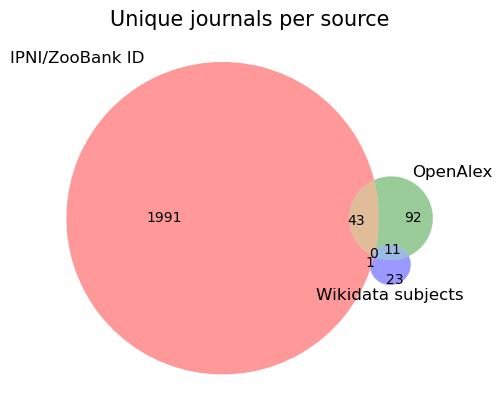

In [8]:
# Venn diagram
ipnizoo = set(journals[journals["source"]=="IPNI or ZooBank ID"]["title"])
openalex = set(journals[journals["source"]=="OpenAlex taxonomy concept"]["title"])
wikisubjects = set(journals[journals["source"]=="Wikidata taxonomic subject"]["title"])

venn3([ipnizoo, openalex, wikisubjects], ("IPNI/ZooBank ID", "OpenAlex", "Wikidata subjects"))
plt.title("Unique journals per source", fontsize=15)

## 2. Articles

- total number
- number with at least one European author

In [9]:
print("Number of articles related to taxonomy: " + str(len(set(articles["id"]))))

Number of articles related to taxonomy: 111379


In [2]:
eu_articles = pd.read_pickle("../data/interim/eu_filtered_articles.pkl")

In [11]:
print("Number of articles related to taxonomy with at least one European author: " +\
      str(len(set(eu_articles["id"]))))

Number of articles related to taxonomy with at least one European author: 33794


## 3. Authors

In [5]:
eu_authors = pd.read_csv("../data/processed/european_taxonomic_authors_no_duplicates.tsv", sep="\t")

In [13]:
print("Number of European authors before disambiguation: "+\
      str(len(eu_authors)))

Number of European authors before disambiguation: 47292


In [3]:
eu_disamb_authors = pd.read_pickle("../data/processed/european_authors_disambiguated_truncated.pkl")

In [15]:
print("Number of European authors after disambiguation: "+\
      str(len(eu_disamb_authors)))

Number of European authors after disambiguation: 46914


In [6]:
print("Number of European institutions publishing taxonomic articles: "+\
      str(len(set(eu_disamb_authors["inst_id"]))))

Number of European institutions publishing taxonomic articles: 3528


In [12]:
len(set(eu_authors[eu_authors["inst_country_code"]=="BE"]["inst_display_name"]))

62

In [13]:
eu_authors.columns

Index(['Unnamed: 0', 'Index', 'article_id', 'author_position', 'author',
       'institutions', 'countries', 'is_corresponding', 'raw_author_name',
       'raw_affiliation_string', 'raw_affiliation_strings', 'author_id',
       'author_display_name', 'author_orcid', 'inst_id', 'inst_display_name',
       'inst_ror', 'inst_country_code', 'inst_type', 'inst_lineage',
       'countries_list', 'id', 'doi', 'title', 'display_name',
       'publication_year', 'publication_date', 'ids', 'language',
       'primary_location', 'type', 'type_crossref', 'open_access',
       'authorships', 'countries_distinct_count',
       'institutions_distinct_count', 'corresponding_author_ids',
       'corresponding_institution_ids', 'apc_list', 'apc_paid',
       'cited_by_count', 'biblio', 'is_retracted', 'is_paratext', 'concepts',
       'mesh', 'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'referenced_works_count',
       'referenced_works', 'related

## 4. Taxonomy

Total number of families within Plantae:
Total number of families within Animalia:
Total number of families within Fungi:
Total number of families within Protists:
…. See similar figure here: https://data-blog.gbif.org/post/gbif-backbone-taxonomy/

In [16]:
authors_tree = pd.read_pickle("../data/processed/european_authors_disambiguated_with_taxonomy.pkl")

In [17]:
def get_number_families(kingdom_name):
    kingdom = []

    for author in authors_tree.itertuples():
        if kingdom_name in author.kingdoms_subjects:
            kingdom.append(author)
            
    kingdom_df = pd.DataFrame(kingdom)
    
    families = []
    
    for author in kingdom_df.itertuples():
        for family in author.families_subjects:
            families.append(family)
            
    return len(set(families))

In [18]:
print("Number of plant families in data: " + str(get_number_families("Plantae")))
print("Number of animal families in data: " + str(get_number_families("Animalia")))
print("Number of fungal families in data: " + str(get_number_families("Fungi")))
# no protists in data

Number of plant families in data: 819
Number of animal families in data: 3152
Number of fungal families in data: 725


## 5. Most prolific authors

In [14]:
authors = pd.read_pickle("../data/interim/all_authors_of_european_taxonomic_articles.pkl")

In [15]:
top_authors = authors["author_id"].value_counts()[0:10]

In [31]:
authors.columns

Index(['article_id', 'author_position', 'author', 'institutions', 'countries',
       'is_corresponding', 'raw_author_name', 'raw_affiliation_string',
       'raw_affiliation_strings', 'author_id', 'author_display_name',
       'author_orcid', 'inst_id', 'inst_display_name', 'inst_ror',
       'inst_country_code', 'inst_type', 'inst_lineage', 'countries_list',
       'id', 'doi', 'title', 'display_name', 'publication_year',
       'publication_date', 'ids', 'language', 'primary_location', 'type',
       'type_crossref', 'open_access', 'authorships',
       'countries_distinct_count', 'institutions_distinct_count',
       'corresponding_author_ids', 'corresponding_institution_ids', 'apc_list',
       'apc_paid', 'cited_by_count', 'biblio', 'is_retracted', 'is_paratext',
       'concepts', 'mesh', 'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'referenced_works_count',
       'referenced_works', 'related_works', 'ngrams_url',
       

In [29]:
sum(list(authors["author_id"].value_counts()))/len(list(authors["author_id"].value_counts()))

1.967124212150062

In [16]:
for author_id in top_authors.index:
    print(authors[authors["author_id"]==author_id].iloc[0]["author_display_name"] + \
          " has written " + str(top_authors.loc[author_id]) + " articles")

André Nel has written 156 articles
Paweł Jałoszyński has written 140 articles
Dariusz L. Szlachetko has written 125 articles
Marta Kolanowska has written 122 articles
Sergey G. Ermilov has written 122 articles
Aidas Saldaitis has written 97 articles
Miguel Vences has written 84 articles
Robert Lücking has written 83 articles
Harry Smit has written 76 articles
Anton V. Volynkin has written 69 articles


(array([7.0315e+04, 4.4400e+03, 2.3420e+03, 1.4350e+03, 9.3300e+02,
        6.7500e+02, 4.9100e+02, 4.1000e+02, 2.8100e+02, 2.3600e+02,
        2.0900e+02, 1.5400e+02, 1.4800e+02, 1.1800e+02, 9.7000e+01,
        8.3000e+01, 6.8000e+01, 5.4000e+01, 6.4000e+01, 4.3000e+01,
        4.0000e+01, 2.6000e+01, 3.6000e+01, 2.4000e+01, 2.3000e+01,
        1.8000e+01, 1.8000e+01, 1.3000e+01, 1.2000e+01, 1.5000e+01,
        2.1000e+01, 8.0000e+00, 1.4000e+01, 1.2000e+01, 4.0000e+00,
        6.0000e+00, 8.0000e+00, 9.0000e+00, 7.0000e+00, 4.0000e+00,
        4.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00, 5.0000e+00,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
        2.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

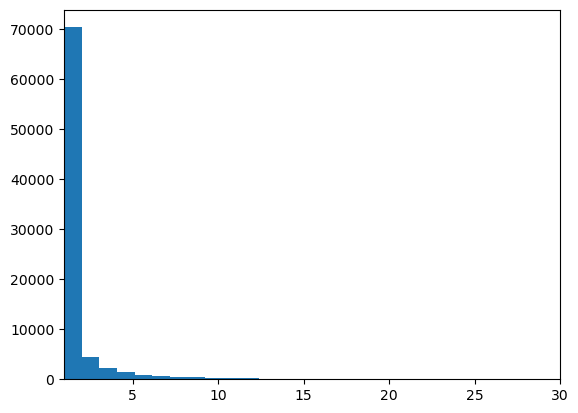

In [25]:
plt.xlim(1,30)
plt.hist(authors["author_id"].value_counts(), bins=150)

## 6. ORCID and Open Access percentages

In [25]:
# total percentage of authors with ORCID
eu_disamb_authors["author_orcid"]

0        https://orcid.org/0000-0002-1018-9316
1                                         None
2        https://orcid.org/0000-0001-7270-3168
3        https://orcid.org/0000-0002-2937-735X
4        https://orcid.org/0000-0001-5107-1472
                         ...                  
46909    https://orcid.org/0000-0002-1948-2367
46910    https://orcid.org/0000-0003-0784-6765
46911                                       {}
46912    https://orcid.org/0000-0003-2736-8094
46913    https://orcid.org/0000-0002-0134-5196
Name: author_orcid, Length: 46914, dtype: object

In [32]:
orcid = 0
no_orcid = 0

for x in eu_disamb_authors["author_orcid"]:
    if isinstance(x, str):
        if x.split(".org/")[0] == "https://orcid":
            orcid += 1
        """ # checking if there are ORCIDs in lists didn't change the results
        elif isinstance(x, tuple) or isinstance(x, set) or isinstance(x, list):
            if isinstance(x[0], str):
                if x[0].split(".org/")[0] == "https://orcid":
                    orcid += 1
                else:
                    no_oricd += 1
            else:
                no_orcid += 1
        """
        else:
            no_orcid += 1
    else:
        no_orcid += 1
        
print("Percentage of authors with an ORCID: " + str(orcid/(no_orcid+orcid)*100))

Percentage of authors with an ORCID: 63.00251524065311


In [45]:
articles = pd.read_pickle("../data/processed/european_taxonomic_articles_with_subjects.pkl")

In [46]:
print("Percentage of European articles that are Open Access: " + \
      str(articles["oa_is_oa"].value_counts()[0]/(articles["oa_is_oa"].value_counts()[0]+articles["oa_is_oa"].value_counts()[1])*100))

Percentage of European articles that are Open Access: 45.265431733443805


In [ ]:
print("Percentage of European articles that are Open Access: " + \
      str(articles["oa_is_oa"].value_counts()[0]/(articles["oa_is_oa"].value_counts()[0]+articles["oa_is_oa"].value_counts()[1])*100))

In [47]:
articles.columns

Index(['id', 'doi', 'title', 'display_name', 'publication_year',
       'publication_date', 'ids', 'language', 'primary_location', 'type',
       'type_crossref', 'open_access', 'authorships',
       'countries_distinct_count', 'institutions_distinct_count',
       'corresponding_author_ids', 'corresponding_institution_ids', 'apc_list',
       'apc_paid', 'cited_by_count', 'biblio', 'is_retracted', 'is_paratext',
       'concepts', 'mesh', 'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'referenced_works_count',
       'referenced_works', 'related_works', 'ngrams_url',
       'abstract_inverted_index', 'cited_by_api_url', 'counts_by_year',
       'updated_date', 'created_date', 'is_authors_truncated',
       'location_is_oa', 'location_landing_page_url', 'location_pdf_url',
       'location_source', 'location_license', 'location_version',
       'location_is_accepted', 'location_is_published', 'source_id',
       'source_display_nam

In [48]:
def species_to_tree(df, backbone):
    # make dictionary of genus, family, order, class, phylum, kingdom for every species
    seen_species = {}

    for species in backbone.itertuples():
        if species.canonicalName not in seen_species:
            seen_species[species.canonicalName] = list(species)[2:]
    
    # associate the full tree with a certain author or article
    genera, families, orders, classes, phyla, kingdoms, lineages = [], [], [], [], [], [], []

    for row in df.itertuples():
        genus, family, order, tclass, phylum, kingdom, lineage = [], [], [], [], [], [], []
                            # python won't allow class as a variable name

        for species in row.species_subject:
            if species in seen_species:
                genus.append(seen_species[species][-1])
                family.append(seen_species[species][-2])
                order.append(seen_species[species][-3])
                tclass.append(seen_species[species][-4])
                phylum.append(seen_species[species][-5])
                kingdom.append(seen_species[species][-6])
                
                lineage.append(seen_species[species][-6:])

        genera.append(set(genus))
        families.append(set(family))
        orders.append(set(order))
        classes.append(set(tclass))
        phyla.append(set(phylum))
        kingdoms.append(set(kingdom))
        lineages.append(lineage)

    df["genera_subjects"] = genera
    df["families_subjects"] = families
    df["orders_subjects"] = orders
    df["classes_subjects"] = classes
    df["phyla_subjects"] = phyla
    df["kingdoms_subjects"] = kingdoms
    df["lineages_subjects"] = lineages
    
    return df

In [51]:
def preprocess_backbone(path="../data/external/backbone/Taxon.tsv", no_blanks=False):
    # GBIF taxonomic bakcbone
    backbone = pd.read_csv(path, sep="\t", on_bad_lines='skip')

    # only Eukarya
    backbone = backbone[(backbone["kingdom"]=="Animalia") | 
                        (backbone["kingdom"]=="Plantae") |
                        (backbone["kingdom"]=="Fungi")]
    # include non-accepted species (synonyms etc), but not blank canonical names 
    backbone = backbone[np.logical_not(backbone["canonicalName"].isnull())].reset_index(drop=True)
    
    if no_blanks:
        backbone = backbone[np.logical_not(backbone["genus"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["family"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["order"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["class"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["phylum"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["kingdom"].isnull())].reset_index(drop=True)

    backbone = backbone.drop_duplicates(ignore_index=True)
    return backbone

In [53]:
import numpy as np

In [54]:
backbone = preprocess_backbone()

C:\Users\melanie\AppData\Local\Temp\ipykernel_26352\2167225142.py:3: DtypeWarning: Columns (9,10,16,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  backbone = pd.read_csv(path, sep="\t", on_bad_lines='skip')


In [55]:
articles2 = species_to_tree(articles, backbone)

In [58]:
plants_open = 0
plants_closed = 0

animals_open = 0
animals_closed = 0

fungi_open = 0
fungi_closed = 0

for row in articles2.itertuples():
    if "Plantae" in row.kingdoms_subjects:
        if row.oa_is_oa:
            plants_open += 1
        else:
            plants_closed += 1
            
    if "Animalia" in row.kingdoms_subjects:
        if row.oa_is_oa:
            animals_open += 1
        else:
            animals_closed += 1
            
    if "Fungi" in row.kingdoms_subjects:
        if row.oa_is_oa:
            fungi_open += 1
        else:
            fungi_closed += 1

In [74]:
print("Percentage of articles about plants that are open access: " + \
      str(plants_open/(plants_open+plants_closed)*100))
print("Percentage of articles about animals that are open access: " + \
      str(animals_open/(animals_open+animals_closed)*100))
print("Percentage of articles about fungi that are open access: " + \
      str(fungi_open/(fungi_open+fungi_closed)*100))

Percentage of articles about plants that are open access: 51.49136577708007
Percentage of articles about animals that are open access: 47.92372257399499
Percentage of articles about fungi that are open access: 56.95006747638327


In [12]:
pi = 3.14

In [20]:
pi = "getal pi"

In [21]:
ook_pi = "getal pi"

In [22]:
id(pi)

2633603430320

In [25]:
id(ook_pi)

2633603430320

In [24]:
ook_pi = pi

In [11]:
ook_pi = pi

In [17]:
ook_pi

'getal pi'

In [15]:
pi = "mopje"

In [16]:
ook_pi

'getal pi'

In [19]:
id(pi)

2633603691312